In [18]:
###########Pre processing steps and split ###############
import pandas as pd
df = pd.read_csv("concatenated.csv")



In [19]:
print(df.head())

                                                 url             price  \
0  https://www.funda.nl/koop/aalsmeer/appartement...  € 403.000 v.o.n.   
1  https://www.funda.nl/koop/aalsmeer/huis-421002...    € 589.000 k.k.   
2  https://www.funda.nl/koop/aalsmeer/huis-429389...  € 774.500 v.o.n.   
3  https://www.funda.nl/koop/aalsmeer/appartement...  € 403.000 v.o.n.   
4  https://www.funda.nl/koop/aalsmeer/huis-429389...  € 774.500 v.o.n.   

                             address  \
0  Appartementen type F (Bouwnr. 77)   
1                       Boomgaard 37   
2          Verandawoning (Bouwnr. 7)   
3  Appartementen Type E (Bouwnr. 64)   
4             Herenhuis (Bouwnr. 22)   

                                             descrip listed_since  \
0  De Tuinen van  Hornmeer  - appartementen  IN V...         2024   
1  Wat een fijne  en  energiezuinige eengezinswon...         2006   
2  De Tuinen van  Hornmeer  - IN  VERKOOP  De omg...         2023   
3  De Tuinen van  Hornmeer  - appartem

In [20]:
####### extract in the numeric price and numeric price m2 ###########

# Extract the numerical price and handle commas and periods
df['numerical_price'] = (
    df['price']
    .str.extract('([\d,\.]+)')[0]
    .str.replace(',', '')
    .str.replace('.', '')
    .astype('Int64')
)

# Correct the extraction pattern to handle decimal and thousand separators
df['numerical_price_per_m2'] = (
    df['last_ask_price_m2']
    .str.extract('([\d,]+)')[0]  
    .str.replace(',', '')  
    .str.replace('.', '')
    .astype(float)  
)

In [21]:
######## extract the tag ############
# Extract 'k.k' or 'v.o.v' into a separate column
df['tag'] = df['price'].str.extract('(k\.k\.|v\.o\.n\.)')

In [22]:
######## extract kind of house and bundle those toghether ##########
# Define a function to categorize kinds of houses
def categorize_house_type(house_type):
    house_type = house_type.lower()
    if 'eengezinswoning' in house_type:
        return 'Eengezinswoning'
    elif 'herenhuis' in house_type:
        return 'Herenhuis'
    elif 'villa' in house_type:
        return 'Villa'
    elif 'bungalow' in house_type:
        return 'Bungalow'
    elif 'woonboot' in house_type:
        return 'Woonboot'
    elif 'appartement' in house_type or 'flat' in house_type or 'maisonnette' in house_type or 'penthouse' in house_type:
        return 'Appartement'
    elif 'woonboerderij' in house_type:
        return 'Woonboerderij'
    elif 'landhuis' in house_type:
        return 'Landhuis'
    elif 'grachtenpand' in house_type:
        return 'Grachtenpand'
    elif 'garage' in house_type:
        return 'Garage'
    elif 'parkeerplaats' in house_type:
        return 'Parkeerplaats'
    elif 'na' in house_type:
        return 'Unknown'
    else:
        return 'Other'

# Apply the categorization function to the 'kind_of_house' column
df['house_category'] = df['kind_of_house'].apply(categorize_house_type)

# Check the new unique categories
unique_house_categories = df['house_category'].unique()
unique_house_categories


array(['Appartement', 'Eengezinswoning', 'Herenhuis', 'Villa', 'Other',
       'Bungalow', 'Woonboot', 'Unknown', 'Woonboerderij', 'Grachtenpand',
       'Garage', 'Landhuis', 'Parkeerplaats'], dtype=object)

In [23]:
#####extract living area and size#######
# Extract the numeric values from 'living_area' and 'size' columns and convert them to float
df['living_area_float'] = df['living_area'].str.extract('(\d+\.?\d*)')[0].str.replace('.', '').astype(float)
df['size_float'] = df['size'].str.extract('(\d+\.?\d*)')[0].str.replace('.', '').astype(float)


In [24]:
########look at errors in translation#######

nan_errors_descrip_en = df['descrip_en'].isna().sum()

short_errors_descrip_en = df['descrip_en'].str.len() < 3


pattern_errors_descrip_en = df['descrip_en'].str.contains('^[^a-zA-Z]*$', regex=True)

# Calculate the number of each type of error
nan_error_count_descrip_en = nan_errors_descrip_en
short_error_count_descrip_en = short_errors_descrip_en.sum()
pattern_error_count_descrip_en = pattern_errors_descrip_en.sum()
# Display the count of each type of error
print(nan_error_count_descrip_en, short_error_count_descrip_en, pattern_error_count_descrip_en)

# Let's check for entries in the 'descrip_en' column that contain the word "ERROR"
error_entries_descrip_en = df['descrip_en'].str.contains('ERROR', case=False, na=False)

# Calculate the number of entries with "ERROR"
error_count_descrip_en = error_entries_descrip_en.sum()

# Display the number of entries with "ERROR"
print(error_count_descrip_en)


0 5 5
437


In [25]:
# Extract rows where 'descrip_en' contains short errors or pattern errors
errors = df[short_errors_descrip_en | pattern_errors_descrip_en| error_entries_descrip_en]
errors.to_csv("errors.csv", index=False)

In [27]:
#####remove the collumn neighbourhoud name####

na_count = df['neighborhood_name'].isna().sum()
nan_string_count = df['neighborhood_name'].str.contains('NAN', case=False, na=False).sum()
na_string_count = df['neighborhood_name'].str.contains('^NA$', case=False, na=False).sum()
zero_count = (df['neighborhood_name'] == '0').sum()
df.drop('neighborhood_name', axis=1, inplace=True)
na_count, nan_string_count, na_string_count, zero_count

(0, 0, 74653, 0)

In [28]:
#####extract zipcode#######
df['zip_code_4_digits'] = df['zip_code'].str.extract('(\d{4})')


######apply pp4 longitude and lattitude on zipcode#####

zip_code_data = pd.read_csv("4pp.csv")

zip_code_data['postcode'] = zip_code_data['postcode'].astype(str)

merged_data = pd.merge(
    df,
    zip_code_data[['postcode', 'latitude', 'longitude']],
    left_on='zip_code_4_digits',
    right_on='postcode',
    how='left'
)

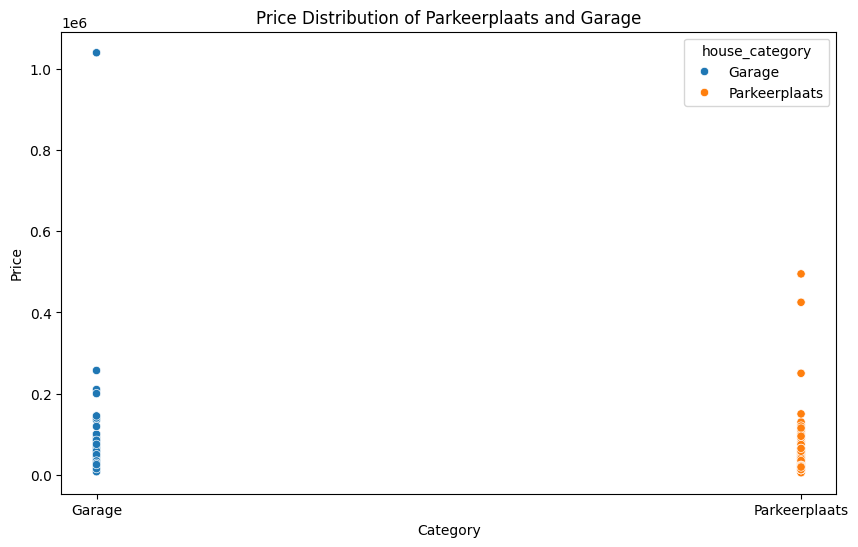

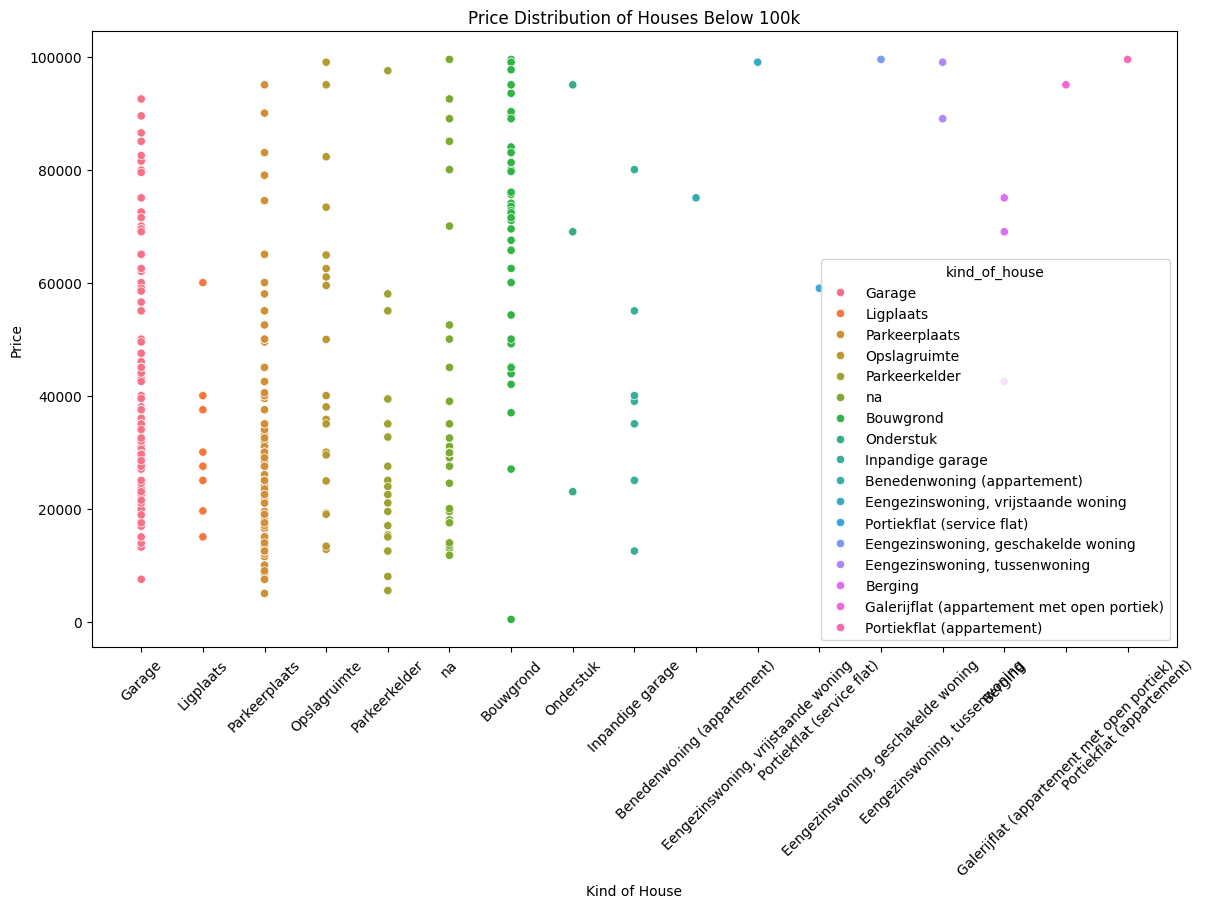

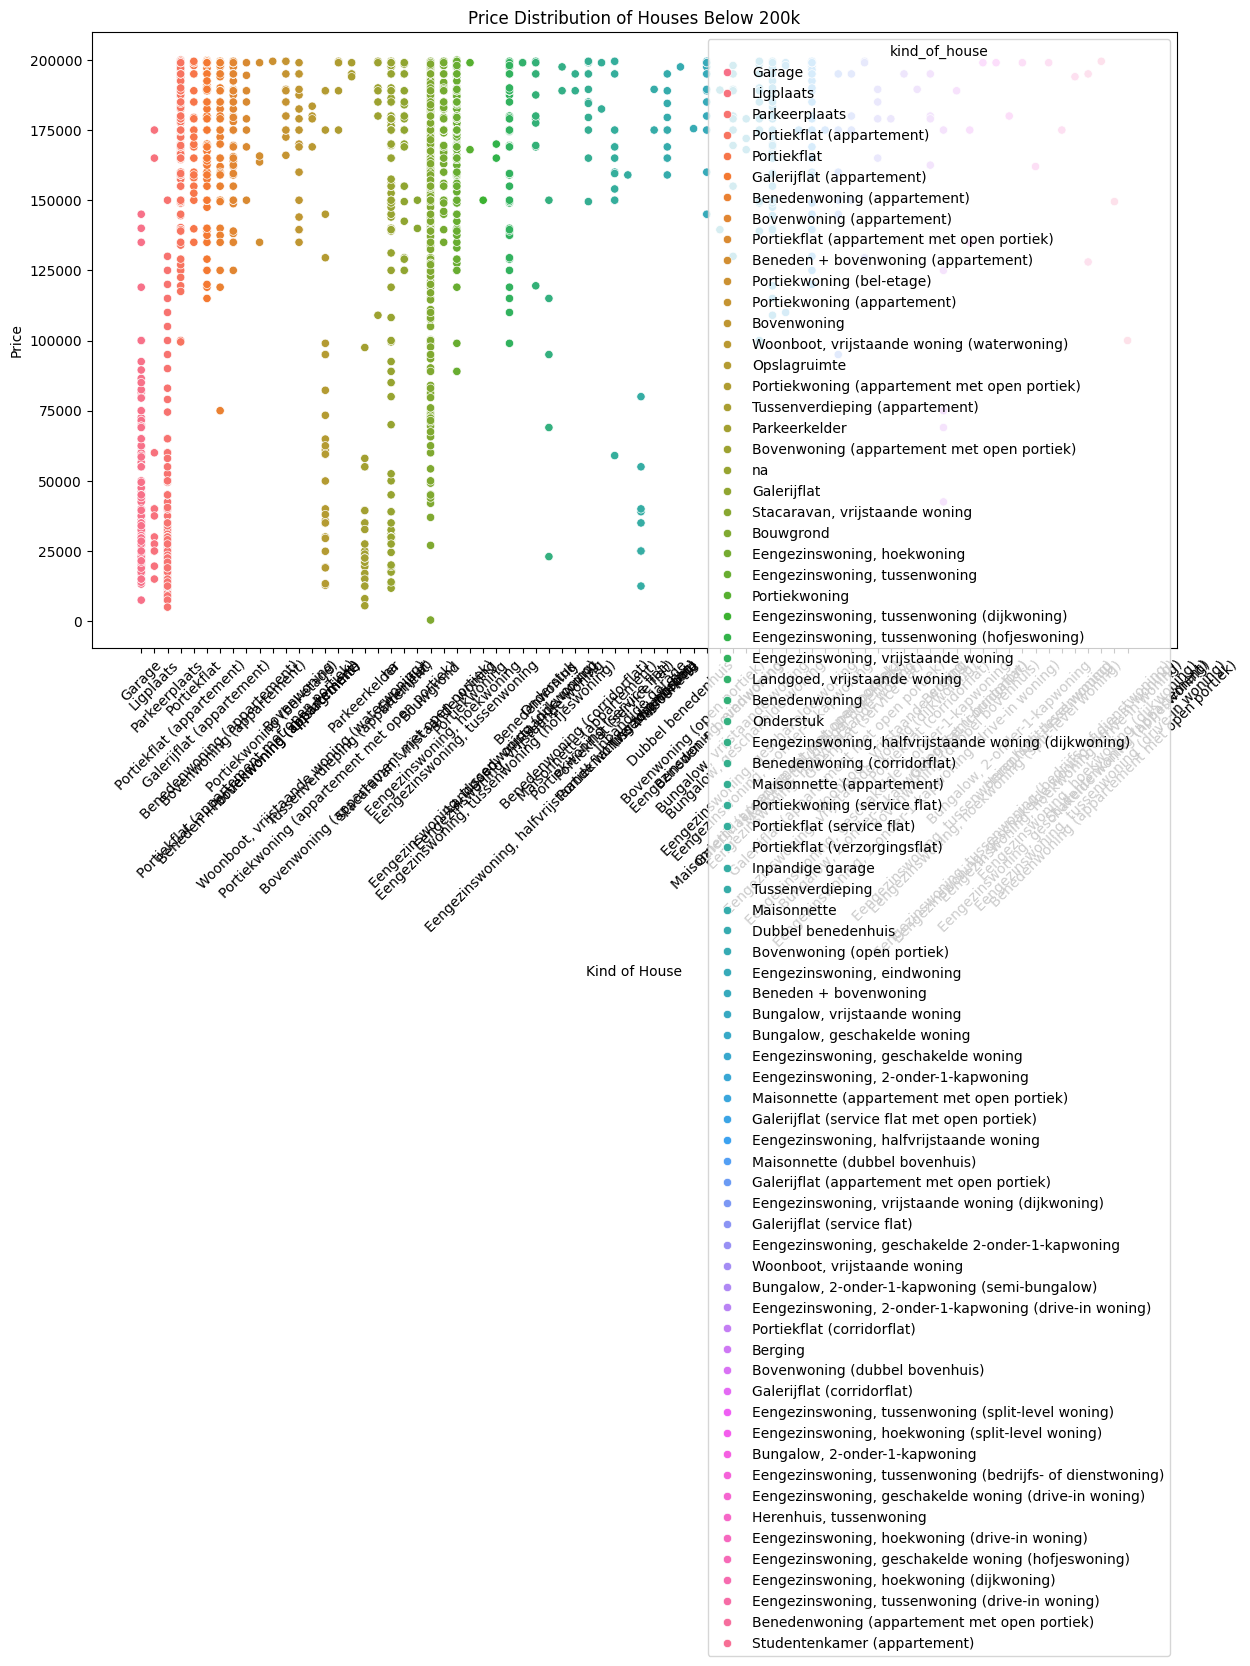

In [34]:
##### look at all the cheap houses #####

import matplotlib.pyplot as plt
import seaborn as sns
# Count instances of 'Parkeerplaats' (Parking) in the 'house_category' column
parking_count = merged_data['house_category'].str.contains('Parkeerplaats', case=False, na=False).sum()
garage_count = merged_data['house_category'].str.contains('Garage', case=False, na=False).sum()
below_100k = merged_data[merged_data['numerical_price'] < 100000]
below_100k_parking_count = below_100k['house_category'].str.contains('Parkeerplaats', case=False, na=False).sum()
below_100k_garage_count = below_100k['house_category'].str.contains('Garage', case=False, na=False).sum()
below_100k_parking_garage_count = below_100k_parking_count + below_100k_garage_count
below_100k_other_count = below_100k.shape[0] - below_100k_parking_garage_count

parking_count, garage_count, below_100k.shape[0], below_100k_parking_count, below_100k_garage_count, below_100k_other_count


# Define a new DataFrame for parking and garage instances with their prices
parking_garage_df = merged_data[merged_data['house_category'].str.contains('Parkeerplaats|Garage', case=False, na=False)]

# Plot for Parking and Garage with their prices
plt.figure(figsize=(10, 6))
sns.scatterplot(data=parking_garage_df, x='house_category', y='numerical_price', hue='house_category')
plt.title('Price Distribution of Parkeerplaats and Garage')
plt.xlabel('Category')
plt.ylabel('Price')
plt.show()

# Define a new DataFrame for instances below 100k with their kind of house
below_100k_df = merged_data[merged_data['numerical_price'] < 100000]

# Plot for all instances below 100k with kind of house
plt.figure(figsize=(14, 8))
sns.scatterplot(data=below_100k_df, x='kind_of_house', y='numerical_price', hue='kind_of_house')
plt.xticks(rotation=45)
plt.title('Price Distribution of Houses Below 100k')
plt.xlabel('Kind of House')
plt.ylabel('Price')
plt.show()

# Define a new DataFrame for instances below 200k with their kind of house
below_200k_df = merged_data[merged_data['numerical_price'] < 200000]

# Plot for all instances below 200k with kind of house
plt.figure(figsize=(14, 8))
sns.scatterplot(data=below_200k_df, x='kind_of_house', y='numerical_price', hue='kind_of_house')
plt.xticks(rotation=45)
plt.title('Price Distribution of Houses Below 200k')
plt.xlabel('Kind of House')
plt.ylabel('Price')
plt.show()




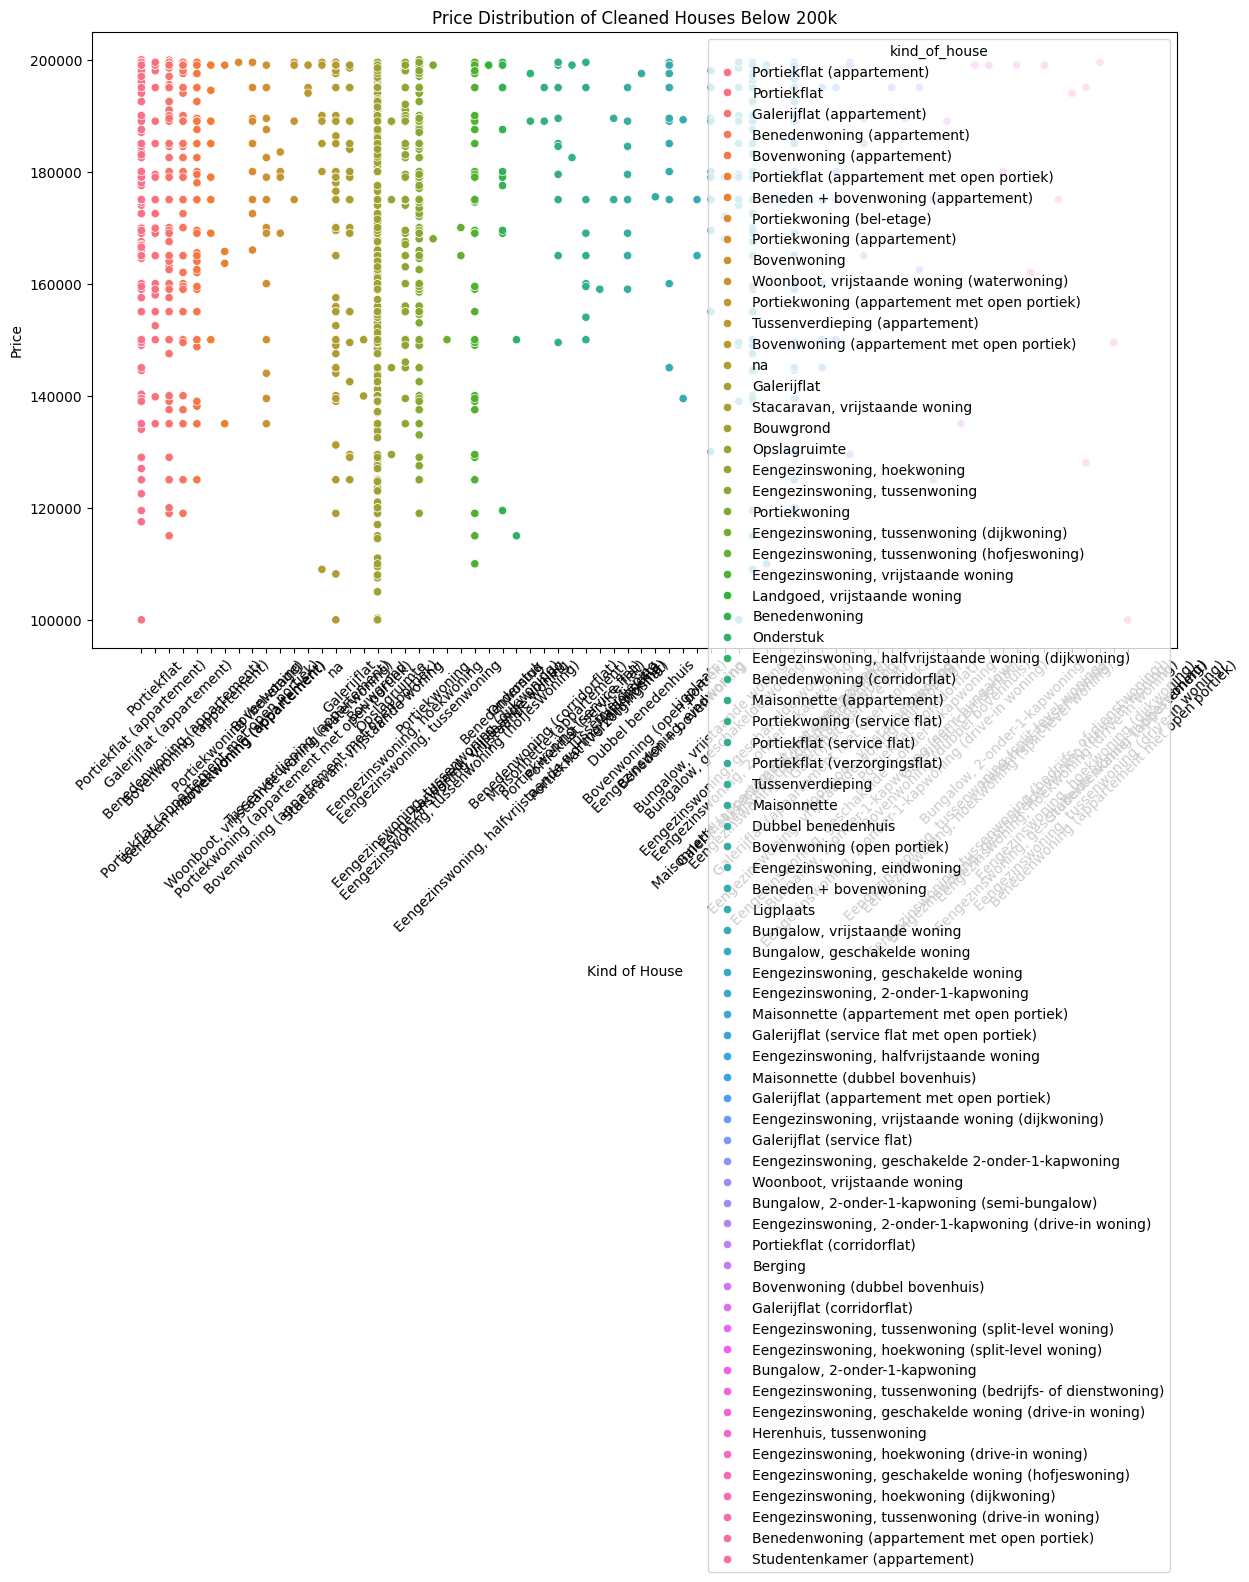

In [35]:
# Remove all instances below 100k
larger_data_cleaned = merged_data[merged_data['numerical_price'] >= 100000]
larger_data_cleaned = larger_data_cleaned[~larger_data_cleaned['house_category'].str.contains('Garage|Parkeerplaats', case=False, na=False)]
cleaned_below_200k_df = larger_data_cleaned[larger_data_cleaned['numerical_price'] < 200000]


plt.figure(figsize=(14, 8))
sns.scatterplot(data=cleaned_below_200k_df, x='kind_of_house', y='numerical_price', hue='kind_of_house')
plt.xticks(rotation=45)
plt.title('Price Distribution of Cleaned Houses Below 200k')
plt.xlabel('Kind of House')
plt.ylabel('Price')
plt.show()


In [36]:
# List of categories to remove from 'kind_of_house'
categories_to_remove = ['Berging', 'Ligplaats', 'Bouwgrond', 'Opslagplaats']
larger_data_cleaned = larger_data_cleaned[~larger_data_cleaned['kind_of_house'].str.contains('|'.join(categories_to_remove), case=False, na=False)]
larger_data_cleaned.shape


(72094, 39)

In [37]:
# Save the cleaned DataFrame to a new CSV file
larger_data_cleaned.to_csv("pre_processed_data_1.csv", index=False)